# Covid long et offre de travail

Projet réalisé en 2025 par Lucile Aubain, Jean Lavallée et Paul Hobeika dans le cadre du cours de *Python pour la data science* enseigné en deuxième année de l'ENSAE.

<a id="introduction"></a>
# Introduction

La pandémie de Covid-19 a contaminé 800 millions de personnes et entraîné le décès de sept millions de personnes dans le monde entre 2020 et 2025, dont 150 000 en France. Ces conséquences directes du Covid-19 s'accompagnent d'effets de plus long terme sur le marché du travail.

Une littérature en médecine montre que de nombreuses personnes ayant contracté le Covid-19 et survécu développent des problèmes de santé persistants. Ces séquelles de long terme recouvrent des symptômes aussi divers que la fatigue chronique, des troubles neurologiques ou des difficultés respiratoires, qui peuvent limiter la capacité des personnes touchées à accomplir leurs activités quotidiennes, y compris leur activité professionnelle ([Ford et al., 2025](https://onlinelibrary.wiley.com/doi/abs/10.1002/ajim.70014?casa_token=NAKQSBiFLa8AAAAA%3AIUjd4EXrl4jU1-7FkTjwP6W7jjW2aly-mTo0LDxL27Oh4bVbCj11uAcFBwdYeCaNNGGWgzkhD-0v5TfP), [MacEwan et al., 2025](https://link.springer.com/article/10.1007/s11606-024-09062-5)). Ces affections sont couramment qualifiées de « Covid long » ([Groff et al., 2021](https://pubmed.ncbi.nlm.nih.gov/34643720/)).

Plusieurs acteurs publics ainsi que des médias ont avancé l’idée que ces affections de long terme auraient réduit l’offre de travail. Un rapport de la *Brookings Institution* ([2022](https://www.brookings.edu/articles/is-long-covid-worsening-the-labor-shortage/)) estime que le Covid long pourrait éloigner jusqu'à 4 millions d'Américains de l'emploi, et ainsi représenter jusqu'à 15 % des postes vacants aux Etats-Unis en 2022. Dans l'Union européenne, un rapport de la Commission européenne ([2024](https://economy-finance.ec.europa.eu/document/download/36713cbb-6cbf-4ddb-8a15-55a4f456e2cb_en?filename=eb077_en.pdf)) estime que le Covid long dans l'UE se traduit par un impact négatif sur l'offre de main-d'œuvre de 0,2 à 0,3 % en 2021 et de 0,3 à 0,5 % en 2022, soit entre 600 000 et 1 million de personnes en 2022. Ces ordres de grandeur sont similaires à ceux estimés par Abraham et Rendell ([2023](https://www.brookings.edu/wp-content/uploads/2023/03/BPEA_Spring2023_Abraham-Rendell_unembargoed.pdf)) pour les Etats-Unis, et par Espinosa Gonzalez et Suzuki ([2024](https://www.oecd.org/content/dam/oecd/en/publications/reports/2024/06/the-impacts-of-long-covid-across-oecd-countries_f662b21c/8bd08383-en.pdf)) pour l'ensemble des pays de l'OCDE. Ce canal par lequel le Covid-19 aurait affecté l'économie pourrait ainsi amener à revoir largement à la hausse son coût économique estimé, jusqu'à 1000 milliards de dollars pour l'OCDE ([Espinoza Gonzalez et Suzuki, 2024](https://www.oecd.org/content/dam/oecd/en/publications/reports/2024/06/the-impacts-of-long-covid-across-oecd-countries_f662b21c/8bd08383-en.pdf)).

Ce travail propose d'étudier l'effet d'une contamination au Covid-19 en 2020 sur l'offre de travail de long terme des salariés dans le contexte français, à partir des données de l'Enquête emploi en continu (EEC). Nous proposons d'abord une méthode pour classer les secteurs d'activités selon leur exposition à la pandémie de Covid-19. DÉVELOPPER.

Nous montrons ensuite que les salariés des secteurs exposés réduisent leur offre de travail de façon persistante, bien après le pic de la pandémie. Une analyse d’événement indique que les travailleurs des secteurs les plus exposés au Covid-19 en 2020 ont une probabilité inférieure d’environ X points de pourcentage d’être en activité un an plus tard, relativement à des travailleurs similaires des secteurs non exposés. A plus long terme, en 2024, DÉVELOPPER.

Ce travail s'inscrit en premier lieu dans la littérature qui étudie les liens entre Covid long et sortie de la population active ([Evans et al., 2021](https://www.sciencedirect.com/science/refhub/S0047-2727(23)00071-3/h0095), [Ziauddeen et al. (2022)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0264331), [Evans et al. (2021)](https://www.sciencedirect.com/science/refhub/S0047-2727(23)00071-3/h0095)). En particulier, Goda et al., ([2023](https://www.sciencedirect.com/science/article/pii/S0047272723000713)) montrent sur des données américaines que les travailleurs ayant été absents une semaine en raison du Covid-19 en 2020 ont 7 % moins de chance d'être toujours actifs un an plus tard que les travailleurs similaires qui n'ont pas manqué le travail pour raisons de santé en 2020. Cet effet de long terme de la pandémie de Covid-19 expliquerait un manque de 500 000 emplois aux Etats-Unis. A partir de données néerlandaises, Bussink et al. ([2025]()) montrent qu’une infection au Covid-19 réduit la probabilité d’emploi des nouveaux entrants sur le marché du travail de environ 1 point de pourcentage dans les trois mois qui suivent leur diplomation. L'effet plus limité du Covid long sur l'offre de travail obtenu par cette seconde étude peut s'expliquer par la plus faible exposition des jeunes adultes au Covid long par rapport à la moyenne des adultes étudiés dans l'étude de Goda et al. (2023).

Ce travail s'inscrit également dans les débats de politique économique relatifs aux travailleurs « manquants » (*missing workers*) observés dans la population active après la pandémie. Reuschke et Houston ([2022](https://www.tandfonline.com/doi/full/10.1080/13504851.2022.2098239)) montrent 80 000 personnes ont quitté leur emploi en raison du COVID long au Royaume-Uni, exacerbant ainsi la pénurie de main-d'œuvre dans le pays. Nos résultats font ainsi écho aux difficultés de recrutement rencontrées par les entreprises de certains secteurs en France entre 2021 et 2023.

Notre travail est par la suite organisé de la façon suivante. Dans la section [Installation](#installation), nous téléchargeons et installons les libraires nécessaires au bon déroulé du code ultérieur. Cette partie appelle également les fonctions utilisées par la suite. Dans la section [Données](#donnees), nous importons et nettoyons nos données avant de proposer une classification des secteurs selon leur exposition au Covid-19 dans la section [Statistiques descriptives](#descriptives). Nous analysons enfin l'effet du Covid sur l'offre de travail par secteur sur le long terme dans la section [Covid long et réduction de l'offre de travail](#modelisation), avant de conclure dans la section [Conclusion](#conclusion).


<a id="sommaire"></a>
## Sommaire
- [Introduction](#introduction)
- [Installation](#installation)
- [Données](#donnees)
- [Statistiques descriptives](#descriptives)
- [Covid long et réduction de l'offre de travail](#modelisation)
- [Conclusion](#conclusion)
- [Bibliographie complémentaire](#bibliographie)

<a id="installation"></a>
# Installation

In [10]:
!pip install -r scripts/requirements.txt

# Modules
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import requests
from io import BytesIO
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from lets_plot import *
from palmerpenguins import load_penguins
from urllib import request
from io import BytesIO
from sklearn.cluster import KMeans

# Fonctions
from scripts import import_eec
from scripts import import_eec_all



<a id="donnees"></a>
# Données

Dans le cadre de ce travail, nous analysons les données relatives aux absences issues des fichiers détails de l'Enquête emploi en continu (EEC). Un travailleur est enregistré comme absent s'il est actuellement employé mais n'a effectué aucune heure de travail durant la semaine de référence de l'EEC. De plus, la « raison principale » de leur absence est demandée à tous les travailleurs absents. Parmi les dix motifs pouvant être invoqués par les employés figure « Congé maladie (y compris arrêt après un accident au travail) ». Nous utilisons ici cette réponse comme proxy d'absence liée à la contamination par le Covid-19.

## Données de l'EEC de 2010 à 2024

### Import

Les variables présentes dans les différentes tables ne sont pas les mêmes d'année en année. Par exemple, la variable d'âge est en 5 modalités et s'appelle `AGE5` en 2018 et 2019 puis elle passe à 6 modalités avec un découpage différent à partir de 2020 et s'appelle alors `AGE6`. Dans un premier temps, on peut ne conserver que les variables qui sont présentes dans toutes les tables, en espérant que les modalités restent les mêmes la plupart du temps. Si on veut en utiliser d'autres, il faudra ajouter des recodages préalables. Pour simplifier les choses, j'ai conservé dans un premier temps uniquement les variables présentes dans toutes les tables. Il y en a 22 qui ont le même nom entre 2010 et 2024. Pour ne pas s'encombrer avec des variables qu'on utilise pas, on peut faire une liste des variables qu'on veut utiliser parmi celles-ci, qu'on peut allonger selon les besoins.

## Sauvegarde intermédiaire

Pour éviter d'avoir à faire systématiquement cette phase d'importation qui est longue (en particulier pour les fichier .dbf), j'ai exporté la base obtenue (avec les 22 variables) dans un fichier `PARQUET` que l'on peut importer directement.

### Assemblage des différents millésimes

Les variables présentes dans les différentes tables ne sont pas les mêmes d'année en année. Par exemple, la variable d'âge est en 5 modalités et s'appelle `AGE5` en 2018 et 2019 puis elle passe à 6 modalités avec un découpage différent à partir de 2020 et s'appelle alors `AGE6`. Dans un premier temps, on peut ne conserver que les variables qui sont présentes dans toutes les tables, en espérant que les modalités restent les mêmes la plupart du temps. Si on veut en utiliser d'autres, il faudra ajouter des recodages préalables.

In [3]:
# Import direct du fichier `PARQUET`
eec_all = pd.read_parquet("https://minio.lab.sspcloud.fr/phobeika/open_eec/eec_all.parquet")


In [4]:
# En fait on ne garde que les actifs en emploi (`ACTEU` == 1)
eec_actifs = eec_all[eec_all['ACTEU'] == "1"]
eec_actifs['RABS'] = eec_actifs['RABS'].astype(str)

/tmp/ipykernel_604377/1482212354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eec_actifs['RABS'] = eec_actifs['RABS'].astype(str)


In [5]:
eec19 = import_eec_all.load_eec_all(years=[2019])
eec20 = import_eec_all.load_eec_all(years=[2020])

Téléchargement depuis l'URL principale : https://www.insee.fr/fr/statistiques/fichier/4809583/fd_eec19_csv.zip
Aucun mot-clé : sélection du fichier le plus gros : FD_EEC_2019.csv
Téléchargement depuis l'URL principale : https://www.insee.fr/fr/statistiques/fichier/5393560/fd_eec20_csv.zip
Aucun mot-clé : sélection du fichier le plus gros : FD_csv_EEC20.csv


# Statistiques descriptives

Nous examinons à présent si, durant la pandémie, les taux d’absence pour raisons de santé ont davantage augmenté parmi les travailleurs dont les professions les exposent à un risque accru de contracter le Covid-19.

## Les absences pour congé maladie comme proxy de la contamination par le Covid-19

Comment pallier l'absence de données sur les contaminations au Covid-19 en 2020 ? Pour déterminer les secteurs d'activité qui ont été les plus touchés sans disposer de données ouvertes permettant de croiser exposition au Covid-19 et secteur d'activité, nous proposons d'utiliser les absences pour congé maladie en 2020 comme proxy de l'exposition au virus lors de cette année. 

Nous faisons l'hypothèse que, dans le contexte pandémique de l'année 2020, les absence au travail pour maladie sont fortement corrélées à la circulation du Covid-19. Pour appuyer cette hypothèse, nous étudions dans cette section la corrélation entre l'intensité pandémique mesurée à partir du nombre d'hospitalisations pour Covid-19 et les arrêts de travail pour maladie.

Après avoir récupéré les données des hospitalisations liées au Covid-19 en 2020 via une API de Santé publique France, nous comparerons l'évolution en base 100 du nombre d'hospitalisations et d'arrêts maladies. Les données de l'enquête emploi en continu étant uniquement détaillées par trimestre, il s'agira d'étudier la corrélation entre ces deux variables à l'échelle trimestrielle. 

ou 

Les taux d’absence pour raisons de santé suivent globalement la hausse et à la baisse des taux d'hospitalisation liés au Covid-19 dans les séries temporelles sur l'année 2020. La Figure 2 présente le nombre total d'arrêt de travail pour cause de maladie et le nombre total d'hospitalisations liées au Covid-19 en France pour chaque trimestre entre janvier 2020 et décembre 2020. La corrélation de ces deux variables est environ de 0.7, laissant penser que la catégorie "arrêts de travail pour cause de maladie" constitue un bon proxy de contamination par le Covid-19 en 2020.


### L'évolution du nombre d'hospitalisations liées au Covid en 2020

Tout d'abord, pour récupérer les données concernant le nombre d'hospitalisations liées au Covid-19, nous avons utilisé l'API Huwise de Santé publique France, présente sur le portail open data Odissé :  
https://odisse.santepubliquefrance.fr/explore/dataset/covid-19-synthese-des-indicateurs-de-suivi-de-la-pandemie-dep/api/?sort=date

Après quelques heures d'errance sur la documentation de l'API (https://help.opendatasoft.com/apis/ods-explore-v2/) et des requêtes fortement limitées dans leur nombre de résultats, nous avons exporté l'ensemble de la base "Covid-19 - Sythèse des indicateurs de suivi de la pandémie", via les commandes indiquées dans la documentation. 

In [ ]:
url_hosp= "https://odisse.santepubliquefrance.fr/api/explore/v2.1/catalog/datasets/covid-19-synthese-des-indicateurs-de-suivi-de-la-pandemie-dep/exports/json"

response = requests.get(url_hosp)

print(response.json) # code 200 => succès

data = response.json()
df=pd.DataFrame(data)
df.head()

<bound method Response.json of <Response [200]>>


,date,lib_dep,dep,tx_pos,tx_incid,to,r,hosp,rea,rad,...,incid_hosp,incid_rea,incid_rad,incid_dchosp,reg_incid_rea,pos,pos_7j,cv_dose1,lib_reg,reg
0,2020-03-21,Eure,27,NaN,NaN,0.091667,NaN,7,3,0,...,3.0,2.0,0.0,0.0,9.0,NaN,NaN,NaN,Normandie,28
1,2020-03-23,Eure,27,NaN,NaN,0.137500,NaN,15,4,0,...,3.0,0.0,0.0,0.0,7.0,NaN,NaN,NaN,Normandie,28
2,2020-03-25,Eure,27,NaN,NaN,0.233333,NaN,22,6,0,...,6.0,1.0,0.0,0.0,18.0,NaN,NaN,NaN,Normandie,28
3,2020-03-26,Eure,27,NaN,NaN,0.312500,NaN,35,9,0,...,12.0,2.0,0.0,1.0,22.0,NaN,NaN,NaN,Normandie,28
4,2020-03-28,Eure,27,NaN,NaN,0.462500,NaN,37,10,1,...,1.0,0.0,1.0,0.0,25.0,NaN,NaN,NaN,Normandie,28


Pour pouvoir grouper et sommer les observations par date, nous avons sélectionné les données de 2020 en s'assurant qu'il existe toujours le même nombre de départements observés pour chaque date (101). Nous avons ensuite représenté graphiquement le nombre d'hospitalisations en fonction du temps, avec des étiquettes mensuelles pour plus de lisibilité


[101]
0


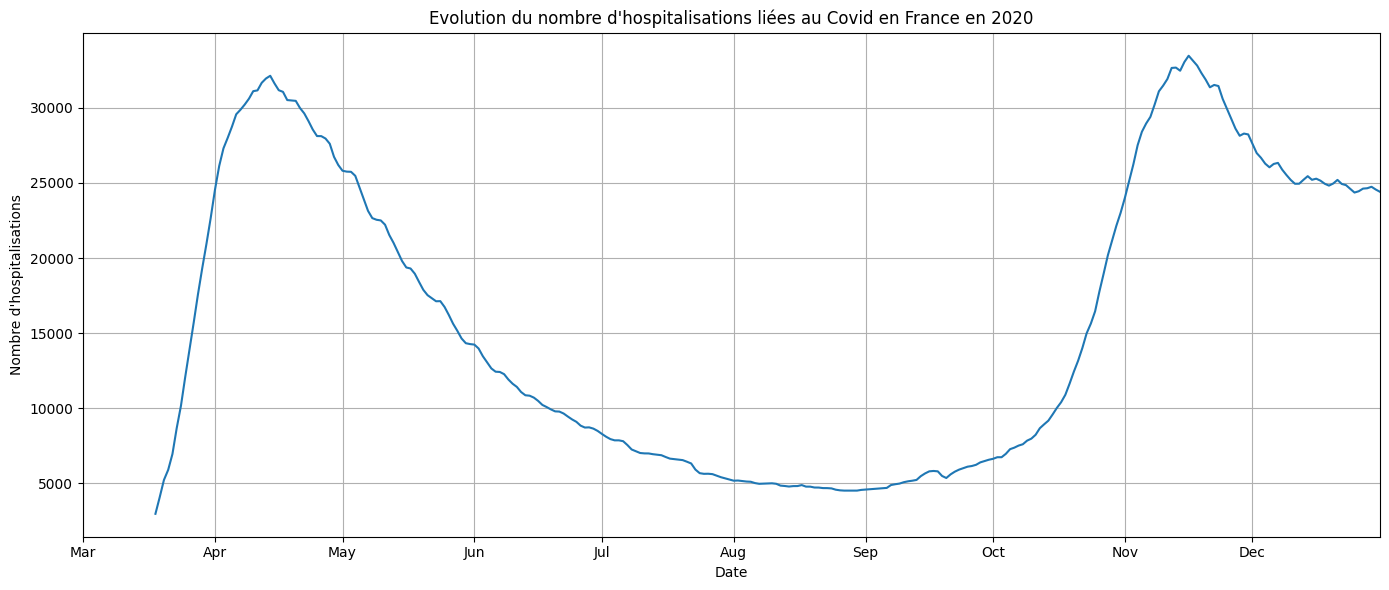

In [13]:
# Etapes préliminaires

df_2020 = df[df['date'].str.contains('2020')].copy() # on ne garde que les données de 2020

count_by_date = df_2020.groupby('date')['dep'].nunique() # nb de départements uniques par date
print(count_by_date.unique()) # le nombre précédent est-il toujours = à 101 = nb de départements ? oui
print(df_2020['hosp'].isna().sum()) # on vérifie qu'il y avait pas de non réponses malgré la présence du département

df_daily = df_2020.groupby('date', as_index=False)['hosp'].sum()

df_daily['date'] = pd.to_datetime(df_daily['date'])   

# Représentation graphique 

plt.figure(figsize=(14,6))
plt.plot(df_daily['date'], df_daily['hosp'])

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.xlim(pd.Timestamp('2020-03-01'), pd.Timestamp('2020-12-31'))   # car les données d'hospitalisations ne commencent qu'en mars

plt.title("Evolution du nombre d'hospitalisations liées au Covid en France en 2020")
plt.xlabel("Date")
plt.ylabel("Nombre d'hospitalisations")
plt.grid(True)
plt.tight_layout()
plt.show()


On retrouve bien les deux "vagues" caractéristiques du Covid en France en 2020, ce qui permet de vérifier la cohérence de nos données

### La corrélation entre hospitalisations liées au Covid-19 et absences du travail pour congé maladie

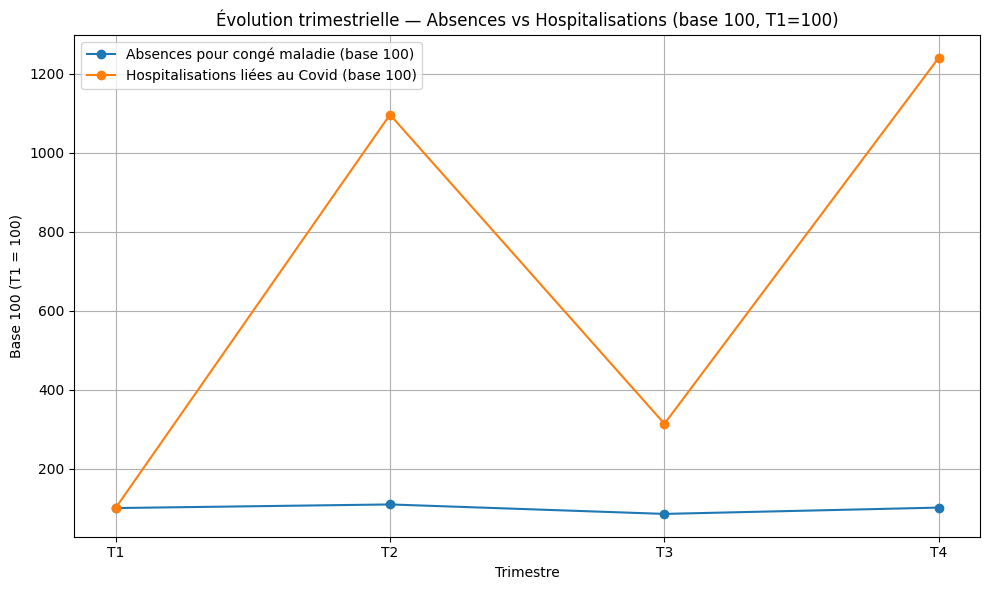

In [20]:
# 1. ABSENCES POUR CONGE MALADIE (RABS = 2)

df_rabs2 = eec20[eec20['RABS'] == 2].copy()
df_trim_abs = (
    df_rabs2.groupby('TRIM')
            .size()
            .reset_index(name='absences')
)

# Passage en base 100 (référence = T1)
df_trim_abs['abs_base100'] = 100 * df_trim_abs['absences'] / df_trim_abs['absences'].iloc[0]

# 2. HOSPITALISATIONS PAR TRIMESTRE

df_daily['year'] = df_daily['date'].dt.year
df_daily['month'] = df_daily['date'].dt.month
df_daily_2020 = df_daily[df_daily['year'] == 2020].copy()

T1 = df_daily_2020[df_daily_2020['month'] == 3]['hosp'].sum()  # attention ici mars uniquement mais on fait l'hypothèse que c'était proche de 0 pour janvier et février
T2 = df_daily_2020[df_daily_2020['month'].isin([4,5,6])]['hosp'].sum()
T3 = df_daily_2020[df_daily_2020['month'].isin([7,8,9])]['hosp'].sum()
T4 = df_daily_2020[df_daily_2020['month'].isin([10,11,12])]['hosp'].sum()

df_trim_hosp = pd.DataFrame({
    "TRIM": [1, 2, 3, 4],
    "hosp": [T1, T2, T3, T4]
})

# Passage en base 100
df_trim_hosp['hosp_base100'] = 100 * df_trim_hosp['hosp'] / df_trim_hosp['hosp'].iloc[0]

# 3. Fusion des deux séries et graphique unique
df_merged = df_trim_abs.merge(df_trim_hosp, on="TRIM")

plt.figure(figsize=(10,6))

plt.plot(df_merged['TRIM'], df_merged['abs_base100'],
         marker='o', label='Absences pour congé maladie (base 100)')
plt.plot(df_merged['TRIM'], df_merged['hosp_base100'],
         marker='o', label='Hospitalisations liées au Covid (base 100)')

plt.title("Évolution trimestrielle — Absences vs Hospitalisations (base 100, T1=100)")
plt.xlabel("Trimestre")
plt.ylabel("Base 100 (T1 = 100)")
plt.xticks([1,2,3,4], ["T1","T2","T3","T4"])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
df_merged.head()

,TRIM,absences,abs_base100,hosp,hosp_base100
0,1,1526,100.000000,166122,100.000000
1,2,1666,109.174312,1821618,1096.554340
2,3,1300,85.190039,520823,313.518378
3,4,1544,101.179554,2061422,1240.908489


In [17]:
correlation = df_merged[['absences', 'hosp']].corr().iloc[0, 1]
print("Corrélation trimestrielle (valeurs brutes) :", correlation)

Corrélation trimestrielle (valeurs brutes) : 0.5865279313708577


## Construction d'une mesure d'exposition au Covid-19 par secteur d'activité

Mettre ici le code pour le random forest

La Figure ci-dessous présente la relation entre les absences pour raisons de santé et le niveau d'exposition au Covid-19 par secteur.

Les résultats obtenus sont cohérents avec ceux de Mongey et al. ([2023](https://link.springer.com/article/10.1007/s10888-021-09487-6)), qui mobilisent les données O\*NET américaines pour classer les professions selon leur aptitude au télétravail et selon le degré de proximité physique avec d’autres personnes requis par les tâches habituelles.


## L'évolution des arrêts de travail pour raison de santé selon l'exposition au Covid-19

Quelques graphiques descriptifs

In [ ]:
LetsPlot.setup_html()

In [ ]:
eec_actifs

,AAC,ACTEU,ANCCHOM,ANNEE,CHPUB,DISPPLC,EXTRIAN,OFFICC,PASTRA,PASTRB,...,RAISTP,SEXE,SOUSEMPL,STATUT,STC,STPLC,TEMP,TPPRED,TRAREF,TRIM
3,,1,,2010,2,,154.013793,3,,,...,,1,,45,2,2,,1,1,1
4,,1,,2010,2,,148.713215,3,,,...,,1,,45,2,2,,1,1,2
5,,1,,2010,2,,160.098185,3,1,,...,,1,,45,2,2,,1,2,3
6,,1,,2010,2,,150.064252,3,,,...,,1,,45,2,2,,1,1,4
8,1,1,,2010,3,,157.836818,1,2,2,...,,1,,43,2,2,,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5933196,<NA>,1,<NA>,2024,7.0,<NA>,54.183092,2.0,2.0,9.0,...,<NA>,1,<NA>,2.0,3.0,2.0,<NA>,1.0,2.0,4
5933197,<NA>,1,<NA>,2024,1.0,1.0,41.192897,2.0,<NA>,<NA>,...,<NA>,2,<NA>,2.0,3.0,1.0,<NA>,1.0,1.0,4
5933200,<NA>,1,<NA>,2024,1.0,<NA>,42.420376,2.0,<NA>,<NA>,...,<NA>,1,<NA>,2.0,3.0,2.0,<NA>,1.0,1.0,4
5933203,<NA>,1,<NA>,2024,7.0,1.0,63.340005,2.0,2.0,9.0,...,9.0,1,1.0,2.0,3.0,1.0,<NA>,2.0,2.0,4


In [ ]:
ggplot(eec_actifs, aes(x = 'ANNEE')) + geom_bar()

<a id="modelisation"></a>

# Covid long et réduction de l'offre de travail

Nous analysons à présent les effets des absences pour raisons de santé sur la participation à la population active à l’aide d’une analyse d’événement au niveau sectoriel.

## Stratégie d'identification

### Doubles-différences

Nous comparons les secteurs exposés au Covid-19 aux secteurs non exposés, dans une fenêtre de quatre ans autour du pic de la pandémie, en 2020. Plus précisément, nous estimons d'abord la spécification suivante :
$$
Y_{it}=\alpha + \tau \text{Post}_{it} + \mathbf{X}_{it} \Lambda_k + \gamma_i + \delta_t + \varepsilon_{it}
$$
où $Y_{it}$ désigne le niveau d'activité du secteur $i$ à la période $t$, $\text{Post}_{i,t}=1[E_i\leq t\leq E_i+5]$ regroupe toutes les années post-2020 en un seul indicateur de traitement, $\mathbf{X}_{i,t}$ est un vecteur de variables de contrôle, les $\gamma_i$ sont des effets fixes par secteur, $\delta_t$ sont des effets fixes par période, et $\varepsilon_{it}$ est le terme d'erreur. Cette approche est semblable à un spécification *two-way fixed effects* (TWFE) statique.

Notre hypothèse d’identification suppose que, hormis l'épisode d’absence pour raisons de santé en 2020, il n’existerait aucune différence moyenne de taux de participation entre les secteurs, une fois que l'on a contrôlé pour leurs caractéristiques initiales $\mathbf{X}_{it}$ ainsi que pour le secteur et la période (effets fixes $\gamma_i$ et $\delta_t$). Dans ce cadre, le terme $\tau$ capture donc l'effet propre de l'exposition au Covid-19 sur la participation au marché du travail des salariés du secteur $i$ après 2020 en moyenne.

### Étude d'évènement

Afin de mieux comprendre l'évolution temporelle des effets de l'exposition au Covid-19, nous estimons une spécification TWFE dynamique, ou "étude d'évènement", en remplaçant le terme $\text{Post}_{it}$ par des indicatrices pour chaque période qui suit l'année 2020. Plus précisément, nous estimons l'étude d’événement suivante :
$$
Y_{it}=\alpha+\sum_{\substack{j \in T \\ j \neq -1}}\tau_{j}L_{i,t+j}+\gamma_i+\delta_t+\varepsilon_{it}
$$
où $T_{i,t+j}=1(j>0)$ et $T\in\{-4,\cdots,+4\}$ de sorte que les coefficients $\tau_j$, pour $j \geq 0$, capturent les effets dynamiques de l'exposition au Covid-19 $j$ période après 2020. Nous fixons $j=-1$ comme période de référence, de sorte que $\tau_{-1}=0$ pour la période immédiatement antérieure à 2020.

Comme nous sommes ici en présence d'une expérience naturelle avec une seule période de traitement (l'année 2020), nous ne sommes pas soumis à la critique de Goodman-Bacon ([2021](https://www.google.com/search?client=safari&rls=en&q=Goodman-Bacon+A+(2021)+Difference-in-differences+with+variation+in+treatment+timing.+J+Econom+225(2)%3A254%E2%80%93277&ie=UTF-8&oe=UTF-8)) et il n'est pas nécessaire d'utiliser les estimateurs robustes de de Chaisemartin et d'Haultfoeuille ([2022](https://www.nber.org/papers/w29873)), Borusyak et al. ([2024](https://academic.oup.com/restud/article/91/6/3253/7601390)) ou encore Callaway et Sant'Anna ([2021](https://www.google.com/search?client=safari&rls=en&q=Callaway+B%2C+Sant%E2%80%99Anna+PH+(2021)+Difference-in-differences+with+multiple+time+periods.+J+Econom+225(2)%3A200%E2%80%93230&ie=UTF-8&oe=UTF-8)). Nous estimons donc cette spécification avec la méthode des moindres carrés ordinaires.

## Résultats

Les figures ci-dessous reportent les coefficients $\tau$ et $\tau_j$ expliqués ci-dessus.

<a id="conclusion"></a>

# Conclusion

# Bibliographie complémentaire

- Jorge A Morales-Camino, SPL07 LONG COVID IMPACT ON WORKERS AND ITS MONITORING IN OCCUPATIONAL HEALTH, *Occupational Medicine*, Volume 74, Issue Supplement_1, July 2024, Page 0, https://doi.org/10.1093/occmed/kqae023.0018 (https://academic.oup.com/occmed/article/74/Supplement_1/0/7706674)
- von Wachter, Till. 2021. "Long-Term Employment Effects from Job Losses during the COVID-19 Crisis? A Comparison to the Great Recession and Its Slow Recovery." *AEA Papers and Proceedings* 111: 481–85.
- Gottlieb M, Chen J, Yu H, et al. Work Impairment and Financial Outcomes Among Adults With vs Without Long COVID. JAMA Netw Open. 2025;8(8):e2526310. doi:10.1001/jamanetworkopen.2025.26310 montre que "financial and work outcomes were worse in participants with current LC up to 3 years after initial infection. COVID-19 vaccination was associated with better work and financial outcomes."
- https://www.sciencedirect.com/science/article/pii/S2772707624001644 montre que "Long COVID reduces work productivity" au Japon
